In [1]:
import os
import sys
import pdb
import numpy as np
import scipy.interpolate
import scipy.io
import matlab.engine
import importlib
import soundfile as sf
import multiprocessing
import functools

import matplotlib.pyplot as plt

import port
importlib.reload(port)

import room_simulator
importlib.reload(room_simulator)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc


In [10]:
eng = matlab.engine.start_matlab();


In [2]:
# fn = '/scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room3x3y4z_materials23wall23floor26ciel/15elev_35az_1.40x1.60y2.00z_l.wav'
# room_materials = [23, 23, 23, 23, 23, 26]
# room_dim_xyz = [3, 3, 4]
# head_pos_xyz = [1.4, 1.6, 2.0]
# head_azim = 0
# src_azim = 35
# src_elev = 15
# src_dist = 1.4

fn = '/scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room5x4y2z_materials1wall15floor16ciel/0elev_45az_3.60x1.40y2.00z_l.wav'
room_materials = [1, 1, 1, 1, 15, 16]
room_dim_xyz = [5, 4, 2]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = 0
src_azim = 45
src_elev = 0
src_dist = 1.4

buffer_pos = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_jitter = False
incorporate_lead_zeros = False

print(fn)
y_l, hrtf_sr = sf.read(fn)
y_r, hrtf_sr = sf.read(fn.replace('_l.wav', '_r.wav'))
brir_francl = np.stack([y_l, y_r], axis=1)
print(brir_francl.shape, hrtf_sr, sr)


/scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room5x4y2z_materials1wall15floor16ciel/0elev_45az_3.60x1.40y2.00z_l.wav
(22050, 2) 44100 44100


In [11]:
importlib.reload(room_simulator)

brir_matlab = room_simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer_pos=buffer_pos,
    sr=sr,
    dur=dur,
    kwargs_room_impulse_hrtf={},
    incorporate_lead_zeros=incorporate_lead_zeros,
    verbose=True,
    eng=eng)


[room simulator] head_pos: [3.6, 1.4, 2.0], src_pos: [4.589949493661167, 2.3899494936611663, 2.0], room_dim: [5, 4, 2]
[room simulator] time elapsed: 189.10834622383118 seconds


In [9]:
importlib.reload(port)

brir_msaddler = port.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer_pos=buffer_pos,
    sr=sr,
    dur=dur,
    use_jitter=use_jitter,
    incorporate_lead_zeros=incorporate_lead_zeros)


[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [4.589949493661167, 2.3899494936611663, 2.0], room_dim: [5, 4, 2]
Loaded KEMAR `hrtf_firs` (Gardner & Martin, 1995): (368, 128, 2)
Loaded KEMAR `hrtf_locs` (Gardner & Martin, 1995): (368, 3)
[get_brir] time elapsed: 29.644722938537598 seconds


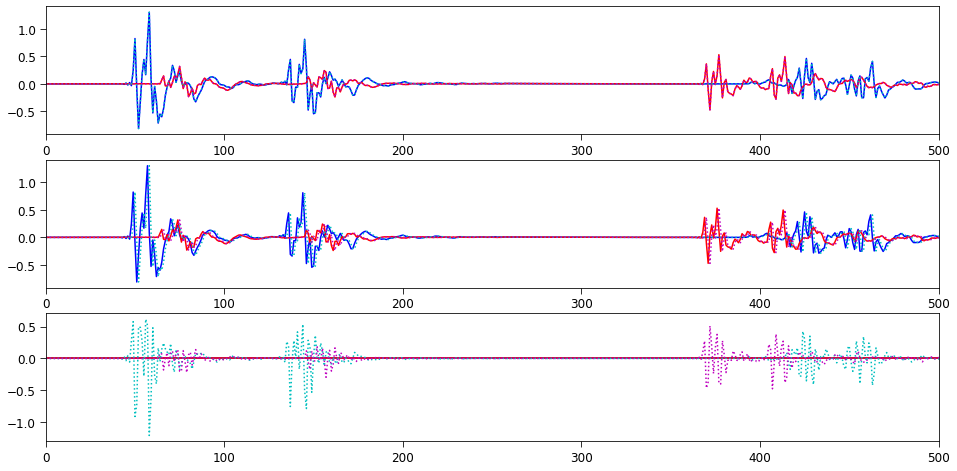

In [13]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=3, ncols=1)
ax[0].plot(brir_msaddler[:, 0], 'b')
ax[0].plot(brir_msaddler[:, 1], 'r')
ax[0].plot(brir_francl[:, 0], 'c', ls=':')
ax[0].plot(brir_francl[:, 1], 'm', ls=':')

ax[1].plot(brir_matlab[:, 0], 'b')
ax[1].plot(brir_matlab[:, 1], 'r')
ax[1].plot(brir_francl[:, 0], 'c', ls=':')
ax[1].plot(brir_francl[:, 1], 'm', ls=':')

ax[2].plot(brir_msaddler[:, 0] - brir_francl[:, 0], 'b')
ax[2].plot(brir_msaddler[:, 1] - brir_francl[:, 1], 'r')
ax[2].plot(brir_matlab[:, 0] - brir_francl[:, 0], 'c', ls=':')
ax[2].plot(brir_matlab[:, 1] - brir_francl[:, 1], 'm', ls=':')

for ax_ in ax:
    util_figures.format_axes(
        ax_,
        xlimits=[0, 500]
    )
plt.show()


In [66]:
room_materials = [1, 1, 1, 1, 15, 16]
room_dim_xyz = [15, 14, 2]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = 0
src_azim = 45
src_elev = 0
src_dist = 1.4

buffer_pos = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_jitter = False
incorporate_lead_zeros = False

importlib.reload(port)

brir_msaddler = port.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    sr=sr,
    dur=dur,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_jitter=use_jitter,
    incorporate_lead_zeros=incorporate_lead_zeros)


[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [4.589949493661167, 2.3899494936611663, 2.0], room_dim: [15, 14, 2]
Loaded KEMAR `hrtf_firs` (Gardner & Martin, 1995): (368, 128, 2)
Loaded KEMAR `hrtf_locs` (Gardner & Martin, 1995): (368, 3)
[get_brir] time elapsed: 4.381653070449829 seconds


In [69]:
importlib.reload(room_simulator)

brir_matlab = room_simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer_pos=buffer_pos,
    sr=sr,
    dur=dur,
    kwargs_room_impulse_hrtf={'jitter':use_jitter, 'meas_sym': use_hrtf_symmetry},
    incorporate_lead_zeros=incorporate_lead_zeros,
    verbose=True,
    eng=eng)


[room simulator] head_pos: [3.6, 1.4, 2.0], src_pos: [4.589949493661167, 2.3899494936611663, 2.0], room_dim: [15, 14, 2]
[room simulator] time elapsed: 5.1440041065216064 seconds


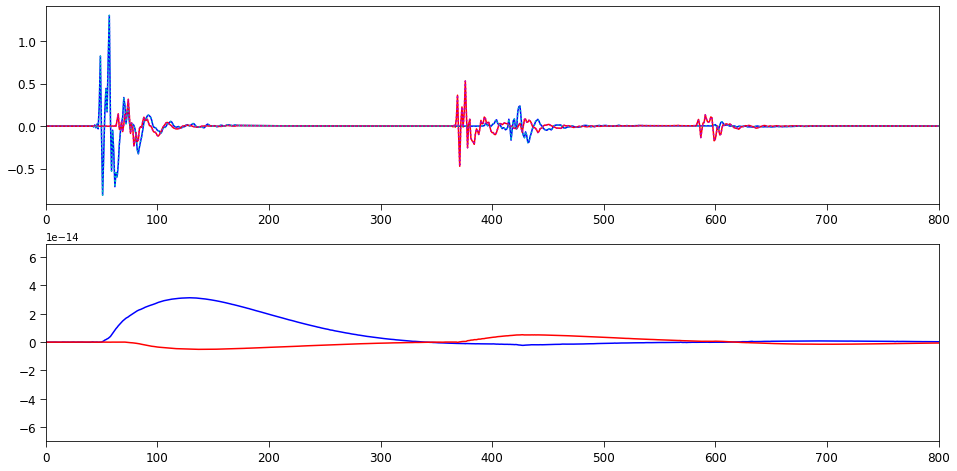

In [70]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)

offset_brir_msaddler = brir_msaddler[1:]
offset_brir_matlab = brir_matlab[:-1]

ax[0].plot(offset_brir_msaddler[:, 0], 'b')
ax[0].plot(offset_brir_msaddler[:, 1], 'r')
ax[0].plot(offset_brir_matlab[:, 0], 'c', ls=':')
ax[0].plot(offset_brir_matlab[:, 1], 'm', ls=':')

ax[1].plot(offset_brir_msaddler[:, 0] - offset_brir_matlab[:, 0], 'b')
ax[1].plot(offset_brir_msaddler[:, 1] - offset_brir_matlab[:, 1], 'r')

for ax_ in ax:
    util_figures.format_axes(
        ax_,
        xlimits=[0, 800],
#         ylimits=[-0.01, 0.01]
    )
plt.show()


In [ ]:
# import cProfile

# func_to_profile = lambda : port.get_brir(
#     room_materials=[23, 23, 23, 23, 23, 26],
#     room_dim_xyz=[3, 3, 4],
#     head_pos_xyz=[1.4, 1.6, 2.0],
#     head_azim=0,
#     src_azim=35,
#     src_elev=15,
#     src_dist=1.4,
#     buffer_pos=0,
#     sr=44100,
#     dur=0.5,
#     use_jitter=False,
#     use_hrtf_symmetry=False,
#     incorporate_lead_zeros=False)

# cProfile.run('func_to_profile()', 'profiler_stats')


In [ ]:
# import pstats
# p = pstats.Stats('profiler_stats')
# p.strip_dirs().sort_stats('cumulative').print_stats()


In [ ]:
np.random.seed(0)

hrtf_firs = np.random.randn(368, 282, 2)

h = np.random.randn(22222, 2)

print(hrtf_firs.shape, h.shape)



# hrtf = hrtf_firs[l]
# new_vals = np.stack([
#     scipy.signal.convolve(
#         ht[:h.shape[0], 0], hrtf[:, 1], mode='full'),
#     scipy.signal.convolve(
#         ht[:h.shape[0], 0], hrtf[:, 0], mode='full'),
# ], axis=1)




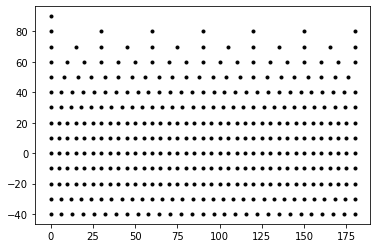

In [62]:
hrtf_locs = scipy.io.loadmat('HRTFs/data_locs.mat')['locs_gardnermartin']
hrtf_locs = np.array(hrtf_locs, dtype=float)
hrtf_locs

fig, ax = plt.subplots()
x = hrtf_locs[:, 1]
y = hrtf_locs[:, 2]
ax.plot(x, y, 'k.')
plt.show()
    